# 何がしたいのか

1. $FFT$で計算した値と$L_{eq}$の値を比べたい。

In [ ]:
def butter_bandpass(lowcut, highcut, order, fs):
    """
    Created on Thu Nov 22
    The function for bandpass filter
    Parameters
    ----------
    lowcut:
        lower frequency side of the butter worth band pass filter in hz
    highcut:
        higher frequency side of the butter worth band pass filter in Hz
    order:
        Order of the butter-worth filter
    fs:
        Sampling frequency
    Returns
    -------
    sos:
        coefficient for sosfilt.
    """
    from scipy.signal import butter
    sos = butter(order, [lowcut / (fs / 2), highcut / (fs / 2)],
                 btype='bandpass', analog=False, output='sos')
    return sos

def octaveband_filter(data, fs, sec, order, how):
    """
    Created on Thu Nov 22
    Butterworth bandpass filter
    Parameters
    ----------
    data:
        input discrete signal
    fs:
        Sampling frequency
    sec:
        duration of input in integer, (s)
    order:
        ~ order butter-worth filter, usually 6 see - 'https://bksv.com/~/media/literature/Product%20Data/bp0163.ashx'
    how:
        OB (31.5~1000(6) or TOB (25~1600(19))
    Returns
    -------
    fc:
        centre frequency bands (Octave or one-third octave)
    y:
        Filtered signal
    """

    import numpy as np
    from scipy.signal import sosfilt

    if how == 'OB':
        n = 1
        fc = np.array([(10**(i / 10)) * 1000 for i in range(-15, 3, 3)])
        fd = 2**(1 / 2 / n)  # Base 2 (OB)
    elif how == 'TOB':
        n = 3
        fc = np.array([(10**(i / 10)) * 1000 for i in range(-16, 3)])
        fd = 2**(1 / 2 / n)  # Base 10 (TOB)
    flo = fc / fd
    fhi = fc * fd
    lowcut = flo
    highcut = fhi

    y = np.zeros([np.size(fc), int(sec * fs)])
    for i in range(np.size(fc)):
        sos = butter_bandpass(lowcut[i], highcut[i], order, fs)
        y[i, :] = sosfilt(sos, data)
    return y, fc

def CPBconv(x, minf, maxf, fres, CPB, how):
    """
    Created on Sat Nov  3
    This function converts narrow band to one-third octave bands. Base 10 system is employed.
    ref IEC6120-1:2014.
    Parameters
    ----------
    x:
        Discrete input signal (i.e. Acceleration, sound pressure)
    minf:
        Minimum frequency range of interest (Hz)
    maxf:
        Maximum frequency range of interest (Hz)
    fres:
        Frequency resolution (Hz)
    CPB:
        'TOB' - One-third octave bands or 'OB' Octave bands
    how:
        'sum' or 'mean' (e.g. for power -sum, for mobility - mean)
    Returns
    -------
    TOB:
        converted discrete signal in one-third octave bands
    TOBf:
        One-third octave band frequencies (Hz)
    OB:
        converted discrete signal in octave bands
    OBf:
        Octave band frequencies (Hz)
    """
    import numpy as np
    if CPB == 'TOB':
        TOB = np.zeros(np.size(np.arange(14, 37)))
        TOBf = np.zeros(np.size(np.arange(14, 37)))
        for i in range(14, 37):
            fc = 10**((i) / 10)  # Base 10 system
            flo = (fc / (2**(1 / 6)))
            fhi = (fc * (2**(1 / 6)))
            freq = np.arange(minf, maxf + 1, fres) #            fband = x[(freq >= flo) & (freq < fhi)]
            if how == 'sum':
                TOB[i -
                    14] = np.sum(np.sqrt(x[(freq >= flo) & (freq < fhi)]**2))
            elif how == 'mean':
                TOB[i -
                    14] = np.mean(np.sqrt(x[(freq >= flo) & (freq < fhi)]**2))
            TOBf[i - 14] = np.round(10**((i) / 10), 3)
        return TOB, TOBf

    elif CPB == 'OB':
        OB = np.zeros(np.size(np.arange(-6, 2)))
        OBf = np.zeros(np.size(np.arange(-6, 2)))
        for i in range(-6, 2):
            fc = 10**3 * (2**(i))
            fd = 2**(1 / 2)
            flo = fc / fd
            fhi = fc * fd
            freq = np.arange(minf, maxf + 1, fres) #            fband = x[(freq >= flo) & (freq < fhi)]
            if how == 'sum':
                OB[i + 6] = np.sum(np.sqrt(x[(freq >= flo) & (freq < fhi)]**2))
            elif how == 'mean':
                OB[i +
                   6] = np.mean(np.sqrt(x[(freq >= flo) & (freq < fhi)]**2))
            OBf[i + 6] = np.round(10**3 * (2**(i)), 3)
        return OB, OBf


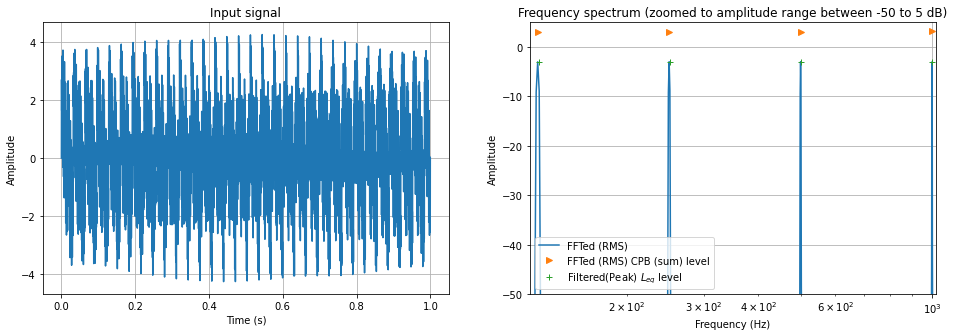

In [ ]:
# 任意のsinusoidを検討する場合は
y_sin_t = np.sin(2*np.pi*t*31.5) + np.sin(2*np.pi*t*63) + np.sin(2*np.pi*t*125) + np.sin(2*np.pi*t*250) + np.sin(2*np.pi*t*500) + np.sin(2*np.pi*t*1000)

# sinusoidの場合はFFTの時にHanningが必要
window = np.hanning(fs)
sp_sin = np.fft.fft(y_sin_t*window*2) # *2が必要な理由は0.5-0.5cos(2pin/M-1)だからだったはず 
# https://numpy.org/doc/stable/reference/generated/numpy.hanning.html

# FFT後の片側のRMSは
y_sin_f = np.sqrt(2) * np.abs(sp_sin[0:int(fs/2)]) / fs # or fs

# Filterを通すと
y_sin_filt,fc = octaveband_filter(y_sin_t, fs, sec, 6, 'OB')

# 各Octave band帯域内のFFTの値を算術平均した場合と平均した場合
y_sin_OB_sum, OBf = CPBconv(y_sin_f, 1, int(fs/2), 1, 'OB', 'sum')
y_sin_OB_mean, OBf = CPBconv(y_sin_f, 1, int(fs/2), 1, 'OB', 'mean')

fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(1, 2, 1)# x軸は時刻、y軸は振幅

plt.plot(t, y_sin_t)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Input signal')
ax.grid()

ax = fig.add_subplot(1, 2, 2)# x軸は周波数、y軸はdB

plt.semilogx(f,20*np.log10(y_sin_f), label='FFTed (RMS)')
plt.semilogx(OBf,20*np.log10(y_sin_OB_sum), '>', label='FFTed (RMS) CPB (sum) level')
# plt.semilogx(OBf,20*np.log10(y_sin_OB_mean), 's', label='FFTed (RMS) CPB (mean) level')
# plt.semilogx(fc, 20*np.log10(np.max(y_sin_filt,axis=1)), 'o', label='Filtered(Peak) $L_{max}$ level')
plt.semilogx(fc, 20*np.log10(np.std(y_sin_filt,axis=1)), '+', label='Filtered(Peak) $L_{eq}$ level')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency spectrum (zoomed to amplitude range between -50 to 5 dB)')
ax.set_xlim([120,1020])
ax.set_ylim([-50,5])
ax.legend()
ax.grid()


array([3.51389021, 3.02218021, 3.02663719, 3.04269855, 3.0740414 ,
       3.1331935 ])

わかったこと
 - FFTした信号のRMSレベルと、 - Leqの値はほぼ同じ
 - オクターブバンドフィルターを通した後に平均したもののとオクターブバンドフィルターを通した後に最大値をとったもは3から4dB程度前者が大きい。
 - FFTした値を各オクターブバンド帯域内のエネルギーを合成したものと平均したものはそれぞれ異なる。

- 任意のsinusoidをFFTをした場合でRMSに変換すると上の図のように、31.5, 63, 125, 250, 500, 1000Hzにおいて振幅がおおよそ 0.7 $(1/\sqrt(2))$ となる。31.5Hz帯域が低いのはleakageのため（$\Delta f =1Hz$)

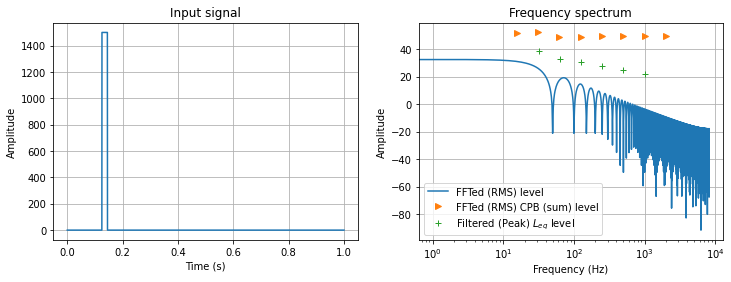

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# FFTの検証
# サンプリング周波数を決めて、信号の長さは1秒間にする。
fs = 2**14
sec = 1
t = np.linspace(0,sec,fs) # 時間軸
f = np.linspace(0,int(fs/2),int(fs/2)) #　周波数軸

# 0のアレイを作って
y_t = np.zeros((fs))

# 20msの入力にする（矩形波）。
y_t[int(fs/8):int(fs/8)+int(0.02*fs)] = 1500

# DFTをする(まど関数無しはRectangular windowと同義)
sp = np.fft.fft(y_t)

# FFT後の片側のRMSは
y_f = np.sqrt(2) * np.abs(sp[0:int(fs/2)]) / fs # or fs

# Filterを通すと
y_filt,fc = octaveband_filter(y_t, fs, sec, 6, 'OB')

# 各Octave band帯域内のFFTの値を算術平均した場合と平均した場合
y_OB_sum, OBf = CPBconv(y_f, 1, int(fs/2), 1, 'OB', 'sum')
y_OB_mean, OBf = CPBconv(y_f, 1, int(fs/2), 1, 'OB', 'mean')

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)# x軸は時刻、y軸は振幅
plt.plot(t, y_t)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Input signal')
ax.grid()

ax = fig.add_subplot(1, 2, 2)# x軸は周波数、y軸はdB
plt.semilogx(f,20*np.log10(y_f), label='FFTed (RMS) level')
plt.semilogx(OBf,20*np.log10(y_OB_sum), '>', label='FFTed (RMS) CPB (sum) level')
# plt.semilogx(OBf,20*np.log10(y_OB_mean), 's', label='FFTed (RMS) CPB (mean) level')
# plt.semilogx(fc, 20*np.log10(np.max(y_filt,axis=1)), 'o', label='Filtered (Peak) $L_{max}$ level')
plt.semilogx(fc, 20*np.log10(np.std(y_filt,axis=1)), '+', label='Filtered (Peak) $L_{eq}$ level')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency spectrum')
ax.grid()
ax.legend()
# ax.set_xlim([20,1020])


わかったこと
 - FFTしたRMSレベルと、各オクターブ帯域内のbinを平均したものはほぼ同じ。
 - オクターブバンドフィルターを通したもののPeakと、各オクターブ帯域内のbinを算術平均したものはほぼ同じ。
 - Leqの値はそれらの間ぐらい(+)